In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import validation_curve, learning_curve, train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')

In [2]:
email_data = pd.read_csv("./spambase.csv")
# exclude id column
email_input = email_data.iloc[:, 1:-1]
email_target = email_data.iloc[:, -1]
mobile_data = pd.read_csv("./mobile_price.csv")
mobile_data.describe()
mobile_input = mobile_data.iloc[:, :-1]
mobile_target = mobile_data.iloc[:, -1]
ss = MinMaxScaler()
email_scaled_input = ss.fit_transform(email_input)
mobile_scaled_input = ss.fit_transform(mobile_input)

In [3]:
def find_best_params(input, target,cv=5):
    input, _, target, _ = data_refine(input, target)
    nn = MLPClassifier(max_iter=300,random_state=42)
    nn_param_names = ['learning_rate_init','hidden_layer_sizes']#,
    nn_param_ranges = [np.linspace(0.001, 0.01,10), range(2,10,1)]
    params = dict(zip(nn_param_names,nn_param_ranges))
    gs=GridSearchCV(nn,params, n_jobs=-1, cv=cv)
    gs.fit(input, target)
    best_index = np.argmax(gs.cv_results_['mean_test_score'])
    print(gs.cv_results_['params'][best_index])
    print(gs.best_score_)
    return gs.best_estimator_

def data_refine(input, target):
    return train_test_split(input, target)

def report(learners, inputs, target):
    trainning_times = []
    test_times = []
    train_scores = []
    test_scores = []
    x_label = ['Original','Original and Kmean','Original and Em', 'Kmean Only', 'Em Only']


    for i in range(len(learners)):
        train_input, test_input, train_target, test_target = data_refine(inputs[i], target)
        train_size, train_score, test_score = learning_curve(learners[i],train_input, train_target, train_sizes=np.linspace(0.1,1,10),cv=5)
        plt.figure()
        plt.plot(train_size,np.mean(train_score,axis=1), label="Train Score")
        plt.plot(train_size,np.mean(test_score,axis=1), label="CV Score")
        plt.title(f'Learning Curve Neural Network with {x_label[i]} features')
        plt.legend(loc='best')
        plt.xlabel("Trainning example(%)")
        plt.ylabel("Score")
        plt.show()



        start = time.time()
        learners[i].fit(train_input, train_target)
        end = time.time()
        trainning_times.append(end-start)
        train_score = learners[i].score(train_input, train_target)
        start = time.time()
        test_score = learners[i].score(test_input, test_target)
        end = time.time()
        test_times.append(end - start)
        train_scores.append(train_score)
        test_scores.append(test_score)

        plt.figure()
        plt.title(f'Loss Curve Neural Network with {x_label[i]} features')
        plt.plot(learners[i].loss_curve_)
        plt.xlabel("epoch")
        plt.ylabel("Loss")
        plt.show()





    # Show barplot trainning time comparision

    plt.figure(figsize=(7,6))
    plt.bar(x_label, trainning_times)
    for i, v in enumerate(trainning_times):
        plt.text(i- 0.2, v+0.002 ,str(round(v,4)))
    plt.xlabel('Feature')
    plt.ylabel('Time')
    plt.title('Trainning time by Features')
    plt.show()

    # Show barplot test time comparision
    # plt.figure(figsize=(7,6))
    # plt.title('Query time by Dimension Reduction')
    # plt.bar(x_label, test_times)
    # for i, v in enumerate(test_times):
    #     plt.text(i-0.2, v,str(round(v,6)))
    # plt.xlabel('Dimension Reduction')
    # plt.ylabel('Time')
    # plt.show()

    plt.figure(figsize=(7,6))
    plt.title('Count Features')
    plt.bar(x_label, [n.shape[1] for n in inputs])
    for i, v in enumerate([n.shape[1] for n in inputs]):
        plt.text(i-0.1, v, str(v))
    plt.xlabel('Features')
    plt.ylabel('Number of features')
    plt.show()

    # Show barplot accuracy scores
    ind = np.arange(len(x_label) )
    width = 0.35
    plt.figure(figsize=(10,8))
    plt.bar(ind, (train_scores), width, label='Train Score')
    plt.bar(ind + width, (test_scores), width,label='Test Score')
    for i, v in enumerate(train_scores):
        plt.text(i-0.1, v+0.005 ,str(round(v,2)))
    for i, v in enumerate(test_scores):
        plt.text(i+width-0.1, v+0.005 ,str(round(v,2)))
    plt.xlabel('Features')
    plt.ylabel('Accuracy score')
    plt.title('Accuracy score by features')

    plt.xticks(ind + width / 2, x_label)
    plt.legend(loc='best')


In [4]:
email_km = KMeans(n_clusters=5, random_state=42)
email_kpred_label = email_km.fit_predict(email_scaled_input)

In [5]:
email_gmm = GaussianMixture(n_components=5, n_init=10)
email_gpred_label = email_gmm.fit_predict(email_scaled_input)

In [6]:
km_email_input=np.append(email_scaled_input, email_kpred_label.reshape(-1,1), axis=1)
em_email_input=np.append(email_scaled_input, email_gpred_label.reshape(-1,1), axis=1)

In [7]:
# km_email_nn = find_best_params(km_email_input, email_target)
# {'hidden_layer_sizes': 4, 'learning_rate_init': 0.01}
# 0.9394202898550725

In [8]:
# em_email_nn = find_best_params(em_email_input, email_target)
# {'hidden_layer_sizes': 6, 'learning_rate_init': 0.008}
# 0.9420289855072465

In [9]:
# km_only_nn = find_best_params(email_kpred_label.reshape(-1,1), email_target)
# {'hidden_layer_sizes': 2, 'learning_rate_init': 0.001}
# 0.8008695652173914

In [10]:
# em_only_nn = find_best_params(email_gpred_label.reshape(-1,1), email_target)
# {'hidden_layer_sizes': 2, 'learning_rate_init': 0.003}
# 0.8684057971014493

In [11]:
original_email_nn = MLPClassifier(max_iter=300,random_state=42, hidden_layer_sizes=8, learning_rate_init=0.002)
# {'hidden_layer_sizes': 8, 'learning_rate_init': 0.002}
# 0.9335403726708075
km_email_nn_copy = MLPClassifier(max_iter=300,random_state=42, hidden_layer_sizes=4, learning_rate_init=0.01)
em_email_nn_copy = MLPClassifier(max_iter=300,random_state=42, hidden_layer_sizes=6, learning_rate_init=0.008)
km_only_nn_copy = MLPClassifier(max_iter=300,random_state=42, hidden_layer_sizes=2, learning_rate_init=0.001)
em_only_nn_copy = MLPClassifier(max_iter=300,random_state=42, hidden_layer_sizes=2, learning_rate_init=0.003)

In [12]:
learners = [original_email_nn, km_email_nn_copy, em_email_nn_copy, km_only_nn_copy, em_only_nn_copy]
inputs = [email_scaled_input, km_email_input, em_email_input, email_kpred_label.reshape(-1,1), email_gpred_label.reshape(-1,1)]

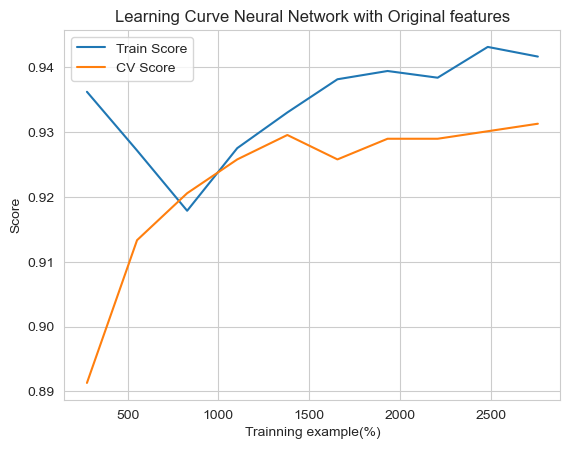

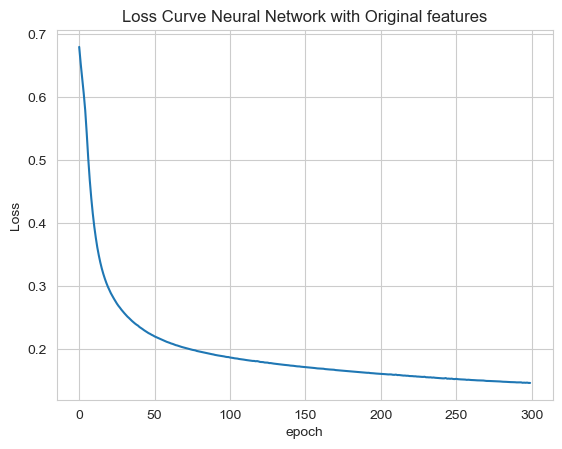

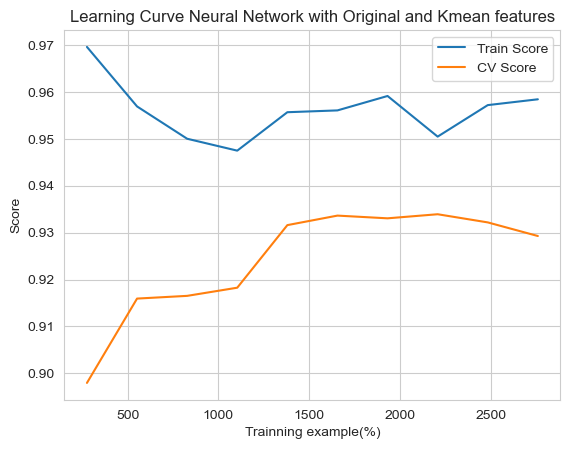

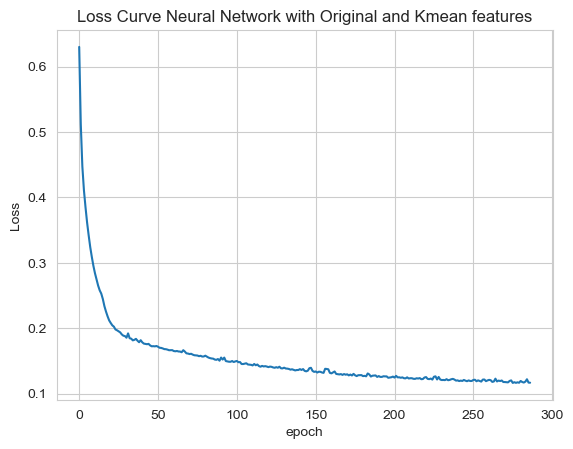

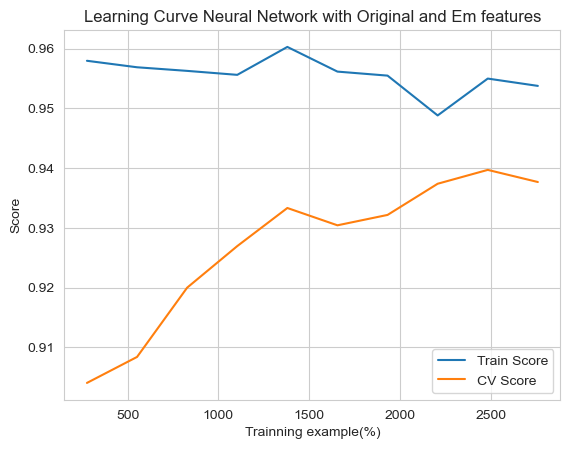

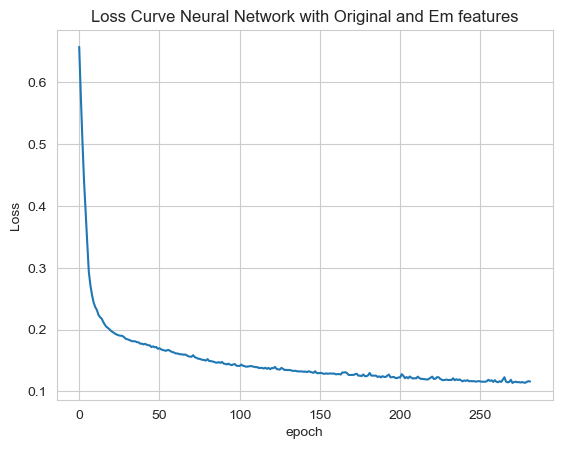

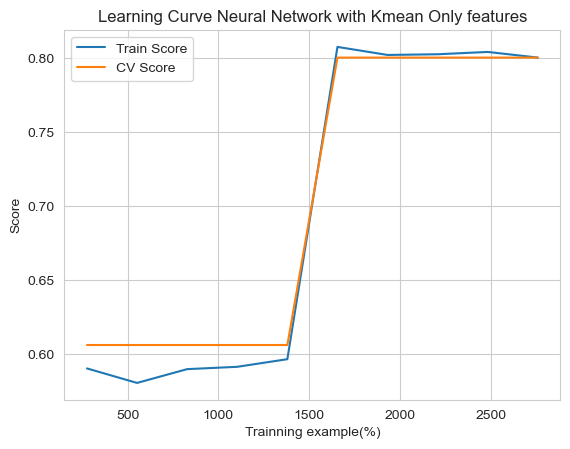

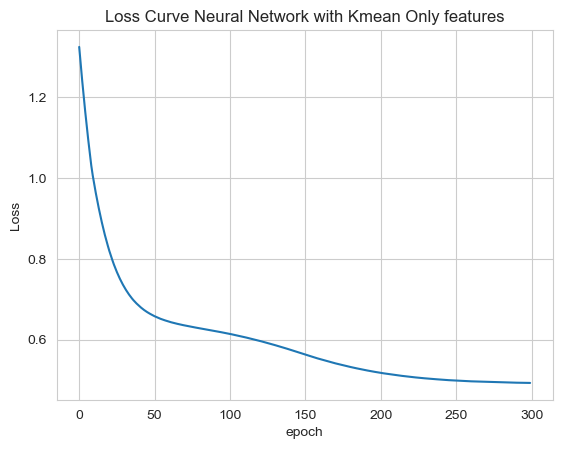

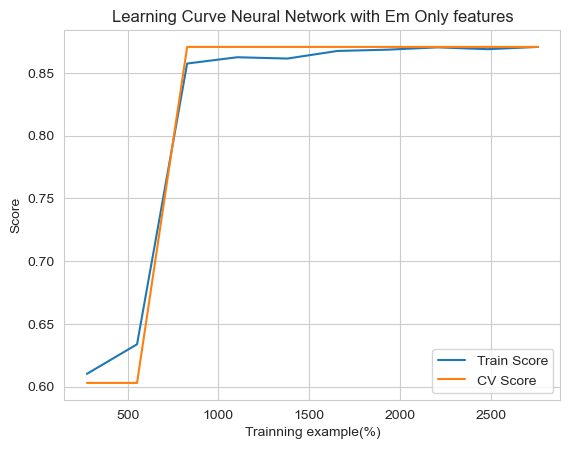

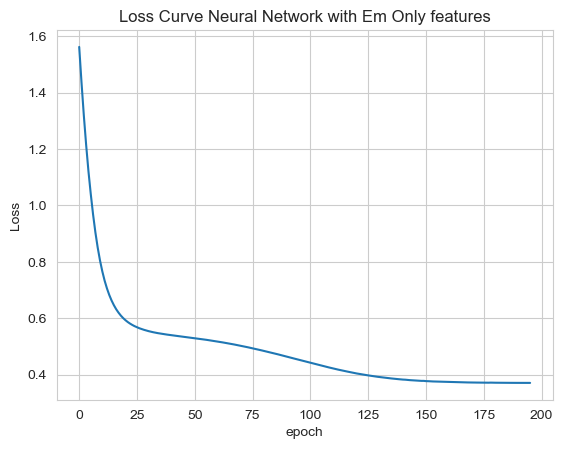

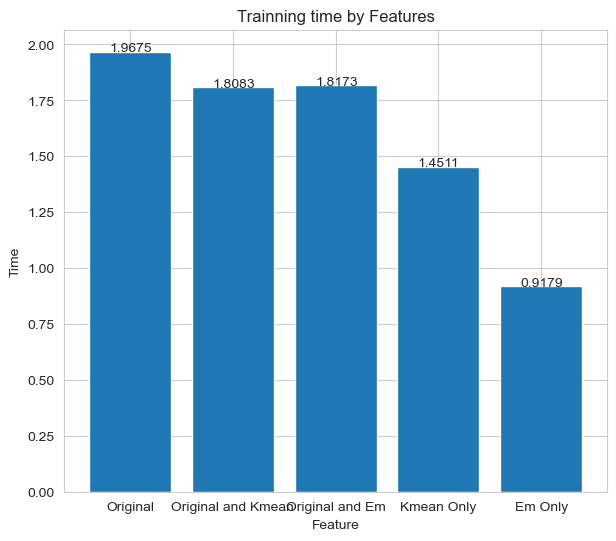

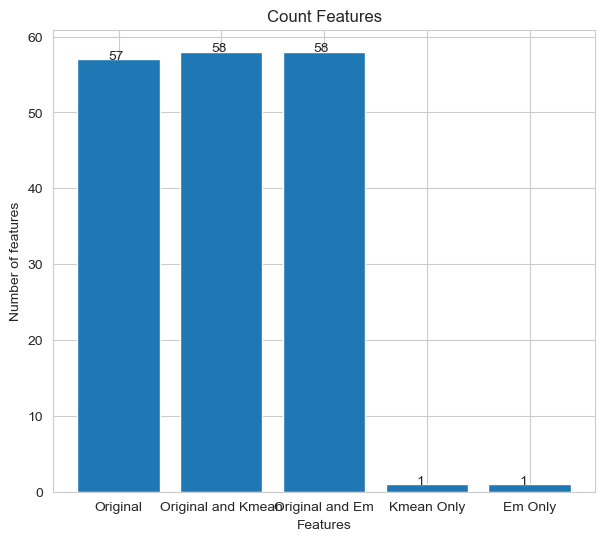

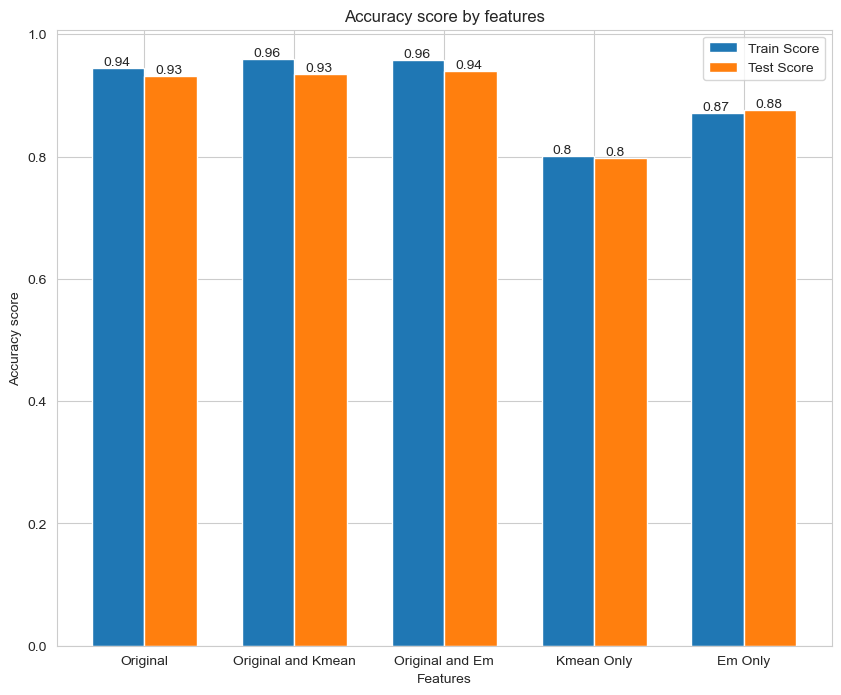

In [13]:
report(learners, inputs, email_target)